# Module 2: MRI Image Denoising

In [ ]:
# setting for running at colab
# !git clone https://<username>:<token>@gitlab.developers.cam.ac.uk/phy/data-intensive-science-mphil/assessments/a2_coursework/yi260.git
# %cd yi260/main
# ! pwd

### Exercise 2.1 Visualisation and identifying noise

In [1]:
import matplotlib.pyplot as plt

# Set default font sizes globally
plt.rcParams.update({
    'font.size': 12,            # Base font size
    'axes.titlesize': 14,       # Title font size
    'axes.labelsize': 12,       # X and Y axis label size
    'xtick.labelsize': 12,      # X-axis tick size
    'ytick.labelsize': 12,      # Y-axis tick size
    'legend.fontsize': 12       # Legend font size
})


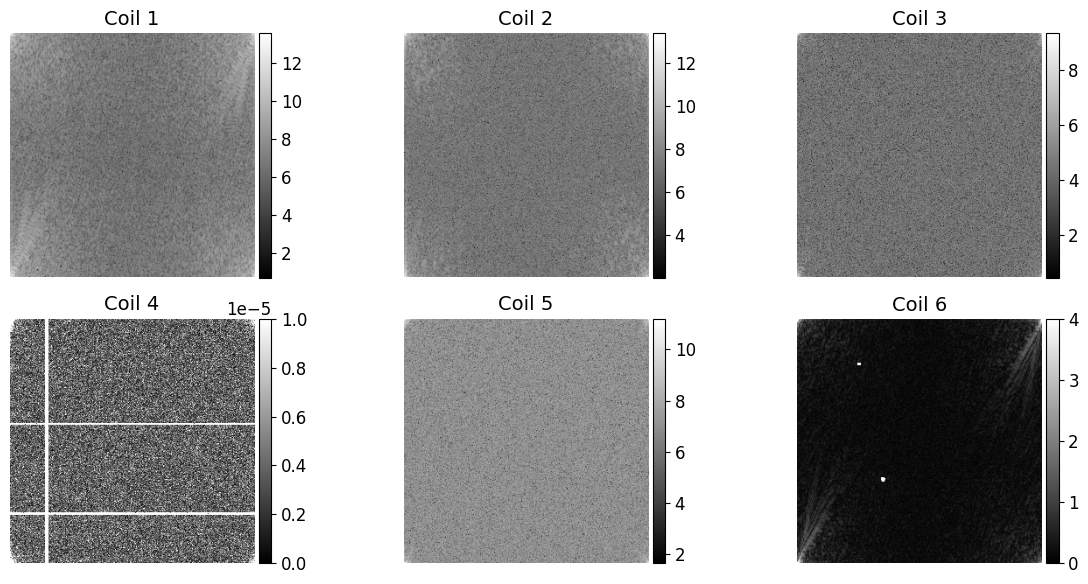

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

kspace = np.load("./Data/Module2/kspace.npy")

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Compute log-scaled k-space magnitude
    data = np.log1p(np.abs(kspace[i, :, :]))
    if i == 3:
        im = ax.imshow(data, cmap="gray", vmin=0, vmax=0.00001)
    elif i == 5:
        im = ax.imshow(data, cmap="gray", vmin=0, vmax=4)
    else:
        im = ax.imshow(data, cmap="gray")
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Create individual colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

plt.tight_layout()
plt.show()


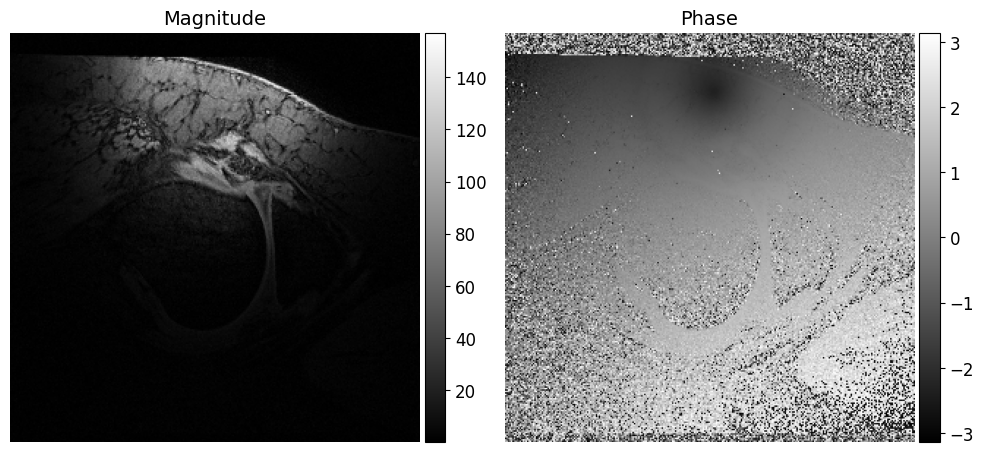

In [3]:
# Transpose the data into image space using the Fourier transform. Create and show a magnitude and phase image from one coil.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Simulate the image-space data from one coil
realspace = np.fft.ifft2(kspace[0, :, :])

# Create figure and two axes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Titles and data for magnitude and phase
images = [
    (np.abs(realspace), "Magnitude"),
    (np.angle(realspace), "Phase")
]

for ax, (data, title) in zip(axes, images):
    im = ax.imshow(data, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

    # Create colorbar that matches image height
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()


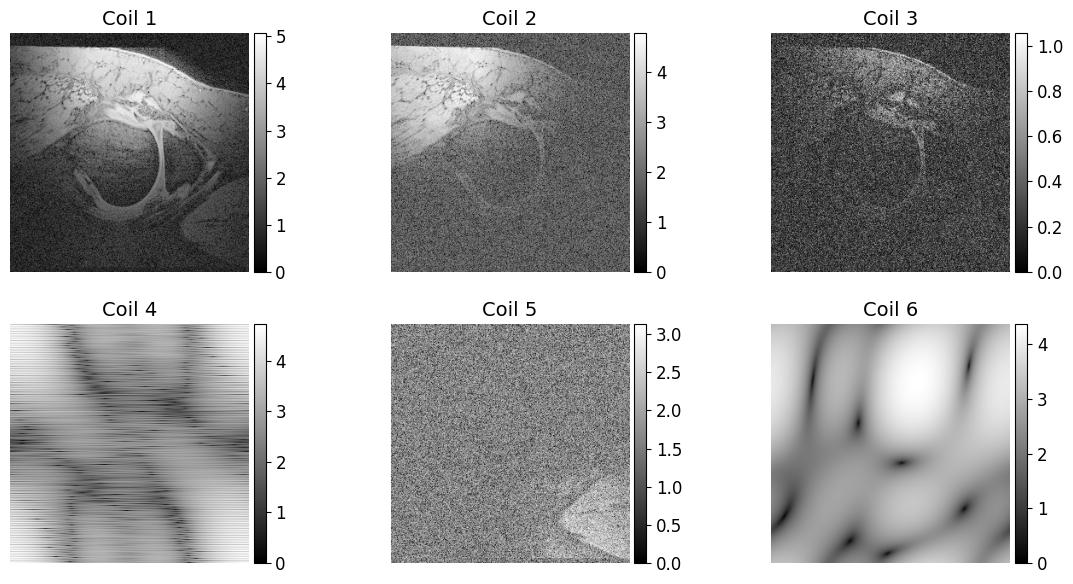

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Transform to image space
realspace = np.fft.ifft2(kspace, axes=(1, 2))

# Compute log-scaled magnitude images
log_images = [np.log1p(np.abs(realspace[i])) for i in range(6)]

# Compute individual color ranges
vmins = [0.] * 6
vmaxs = [np.max(img) for img in log_images]

# Set up plot
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(log_images[i], cmap="gray", vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Create a colorbar for each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

plt.tight_layout()
plt.show()


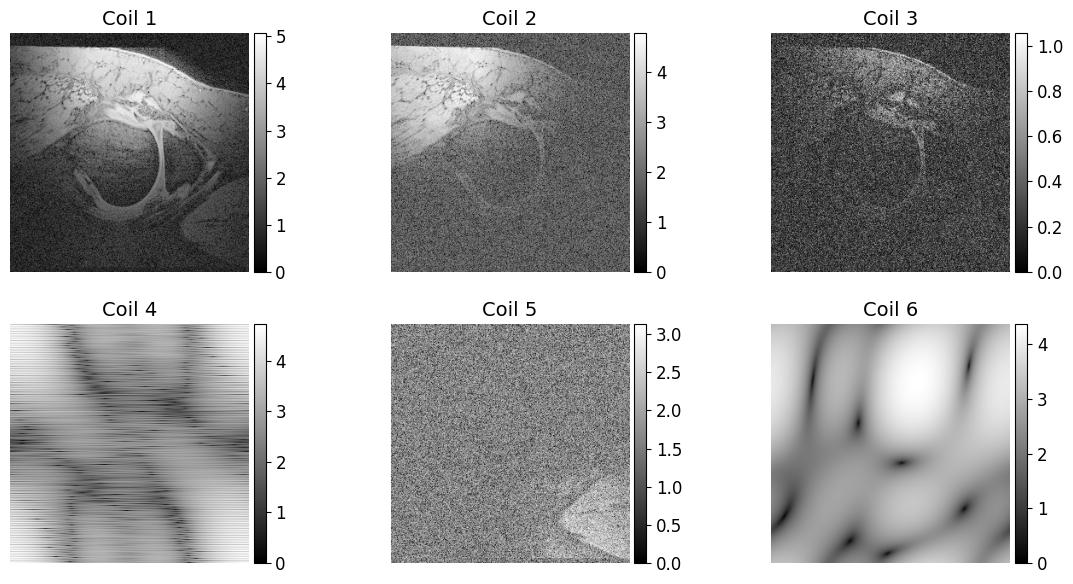

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Transform to image space
realspace = np.fft.ifft2(kspace, axes=(1, 2))

# Compute log-scaled magnitude images
log_images = [np.log1p(np.abs(realspace[i])) for i in range(6)]

# Compute individual color ranges
vmins = [0.] * 6
vmaxs = [np.max(img) for img in log_images]

# Set up plot
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(log_images[i], cmap="gray", vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Create a colorbar for each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

plt.tight_layout()
plt.show()


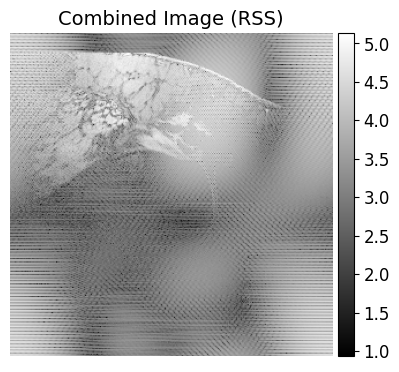

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Combine the realspace images from all coils using root-sum-of-squares
combined = np.zeros_like(realspace[0, :, :], dtype=np.complex64)
for i in range(6):
    combined += realspace[i, :, :]**2.

rss_image = np.sqrt(np.abs(combined))
log_rss_image = np.log1p(rss_image)

# Plot with colorbar
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(log_rss_image, cmap="gray")
ax.set_title("Combined Image (RSS)")
ax.axis("off")

# Add well-matched colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params()

plt.tight_layout()
plt.show()


### Exercise 2.2 Removing noise
#### Try three different denoising methods -- Mean, Gaussian and Wablet filtering

# Preprocess: denoise by thresholding and filling in
Before removing noise in homogeneous filters, peaky noise in coils 4 and 6 are individually treated.
Coil 4 has three lines of prominent noise, which has far larger magnitude than actual signal. This is removed by threatholding.

Coil 6 has a noise in two separate points. Those are filled in by the signal in diagonal location, using the symmetric nature of the signal.


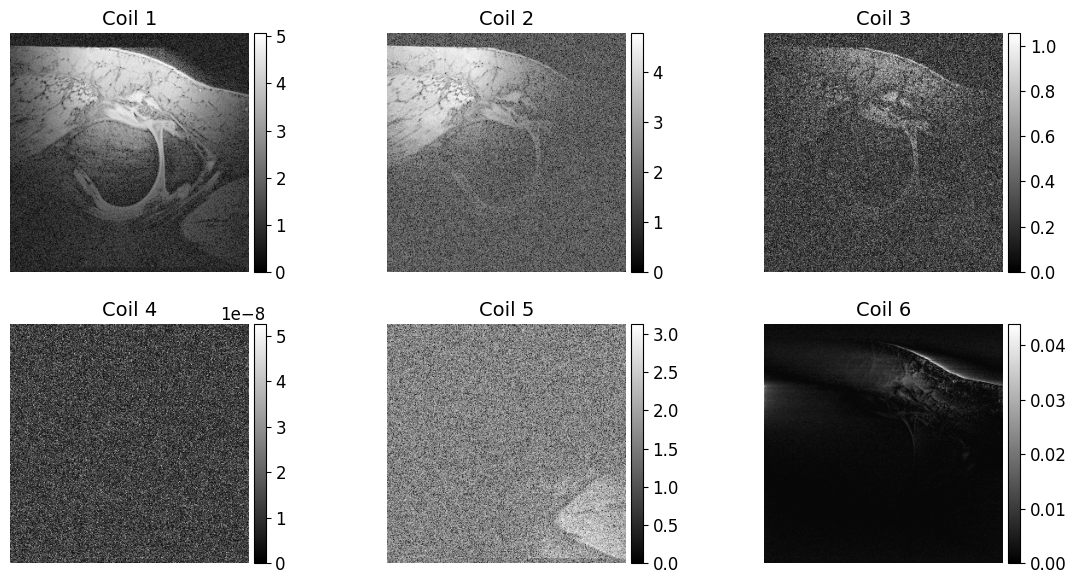

In [7]:
import numpy as np

kspace = np.load("./Data/Module2/kspace.npy")
kspace_denoised=kspace
# dominant noises are apparently larger than certain threshold values, and signal weaker than that
kspace_denoised[3, :, :] = np.where(abs(kspace[3, :, :])>0.00001, 0, kspace[3, :, :])

# Replace noisy left half using complex conjugate, assuming original image are all in real space
H, W = kspace.shape[-2], kspace.shape[-1]
for i in range(H):
    for j in range(W // 2):
        i_mirror = (H - i) % H
        j_mirror = (W - j) % W
        kspace_denoised[5, i, j] = np.conj(kspace[5, i_mirror, j_mirror])

realspace = np.fft.ifft2(kspace_denoised, axes=(1, 2))

# Compute log-scaled magnitude images
log_images = [np.log1p(np.abs(realspace[i])) for i in range(6)]

# Compute individual color ranges
vmins = [0.] * 6
vmaxs = [np.max(img) for img in log_images]

# Set up plot
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(log_images[i], cmap="gray", vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Create a colorbar for each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

plt.tight_layout()
plt.show()

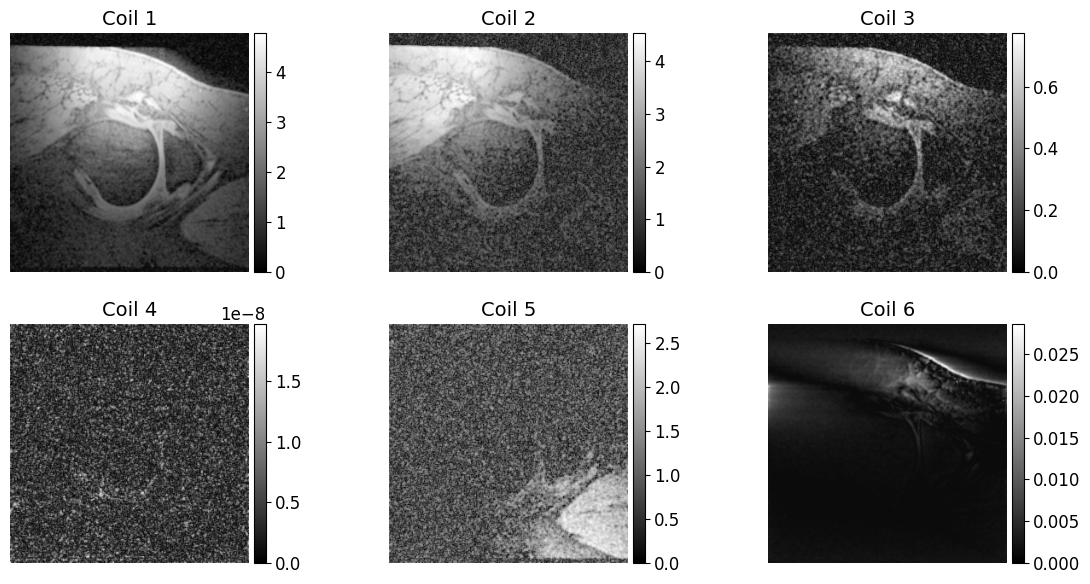

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import uniform_filter

# Apply uniform filter
mean_filtered = np.zeros_like(realspace)
for i in range(6):
    mean_filtered[i] = uniform_filter(realspace[i], size=3)

# Log scale the data
log_filtered = [np.log1p(np.abs(mean_filtered[i])) for i in range(6)]

# Compute per-image vmin/vmax
vmins = [0.] * 6
vmaxs = [np.max(log_filtered[i]) for i in range(6)]

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(log_filtered[i], cmap="gray", vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Individual colorbar using make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

plt.tight_layout()
plt.show()


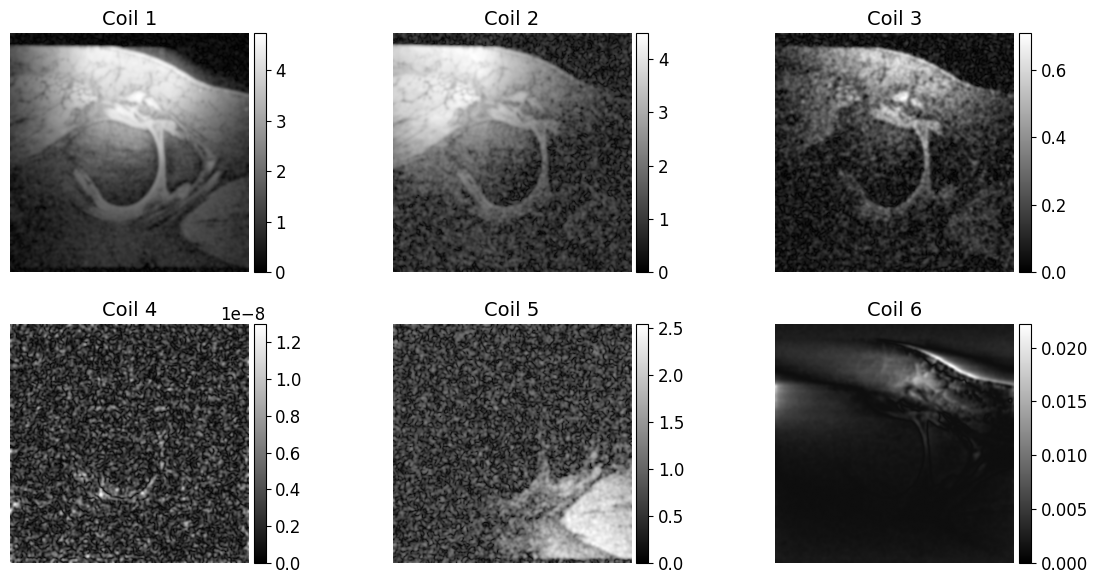

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

# Apply Gaussian filter
gaussian_filtered = np.zeros_like(realspace)
for i in range(6):
    gaussian_filtered[i] = gaussian_filter(realspace[i], sigma=1.5)

# Log-transform filtered data
log_filtered = [np.log1p(np.abs(gaussian_filtered[i])) for i in range(6)]

# Compute per-image colorbar ranges
vmins = [0.] * 6
vmaxs = [np.max(img) for img in log_filtered]

# Set up figure and axes
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(log_filtered[i], cmap="gray", vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Add individual colorbar to each image
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

plt.tight_layout()
plt.show()


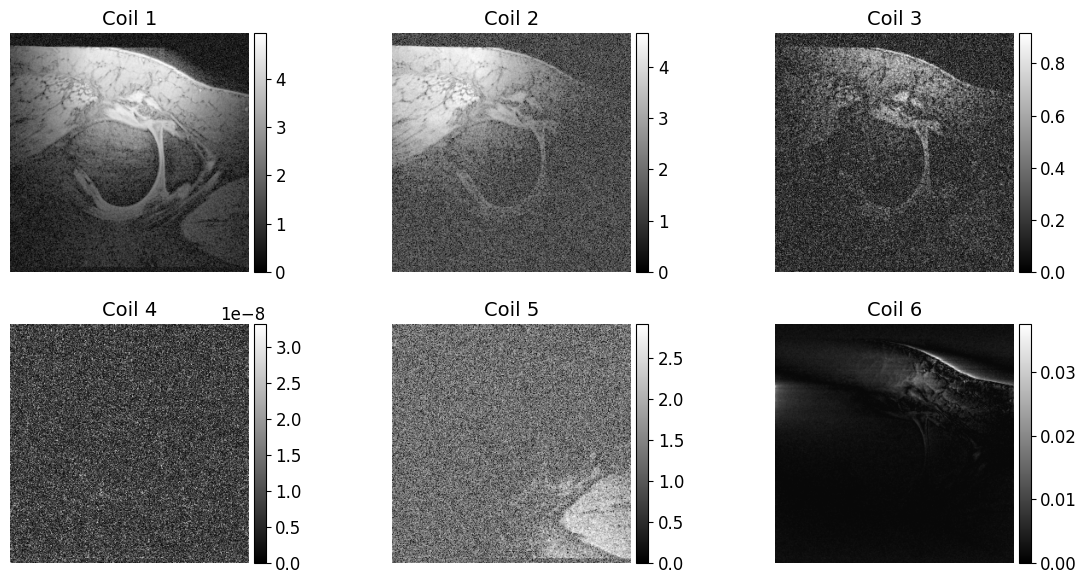

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

# Apply Gaussian filter
gaussian_filtered = np.zeros_like(realspace)
for i in range(6):
    gaussian_filtered[i] = gaussian_filter(realspace[i], sigma=0.5)

# Log-transform filtered data
log_filtered = [np.log1p(np.abs(gaussian_filtered[i])) for i in range(6)]

# Compute per-image colorbar ranges
vmins = [0.] * 6
vmaxs = [np.max(img) for img in log_filtered]

# Set up figure and axes
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(log_filtered[i], cmap="gray", vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Add individual colorbar to each image
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params()

plt.tight_layout()
plt.show()


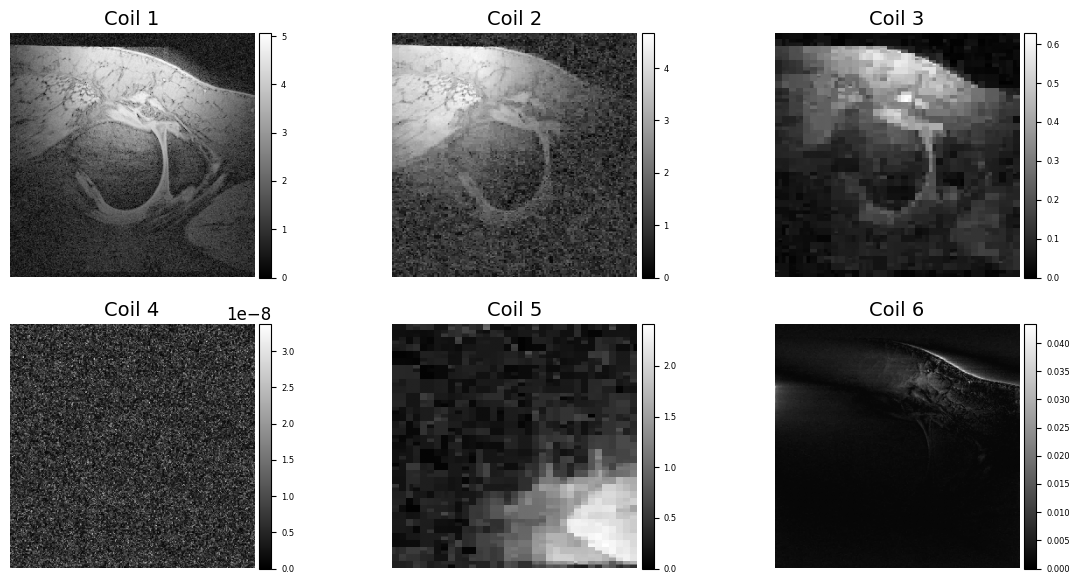

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.restoration import denoise_wavelet

# Denoise real and imaginary parts separately
wavelet_filtered_real = np.zeros_like(realspace)
wavelet_filtered_imag = np.zeros_like(realspace)

for i in range(realspace.shape[0]):
    wavelet_filtered_real[i] = denoise_wavelet(
        realspace[i].real,
        method="BayesShrink",
        mode="soft",
        rescale_sigma=True,
        channel_axis=None
    )
    wavelet_filtered_imag[i] = denoise_wavelet(
        realspace[i].imag,
        method="BayesShrink",
        mode="soft",
        rescale_sigma=True,
        channel_axis=None
    )

# Reconstruct magnitude and phase
denoised_magnitude = np.sqrt(wavelet_filtered_real**2 + wavelet_filtered_imag**2)
denoised_phase = np.angle(realspace)  # Retain original phase
reconstructed = denoised_magnitude * np.exp(1j * denoised_phase)

# Log-transformed magnitude images
log_images = [np.log1p(np.abs(reconstructed[i])) for i in range(6)]
vmins = [0.] * 6
vmaxs = [np.max(img) for img in log_images]

# Plot with individual colorbars
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(log_images[i], cmap="gray", vmin=vmins[i], vmax=vmaxs[i])
    ax.set_title(f"Coil {i + 1}")
    ax.axis("off")

    # Individual colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=6)

plt.tight_layout()
plt.show()


#### Butterworth filtering

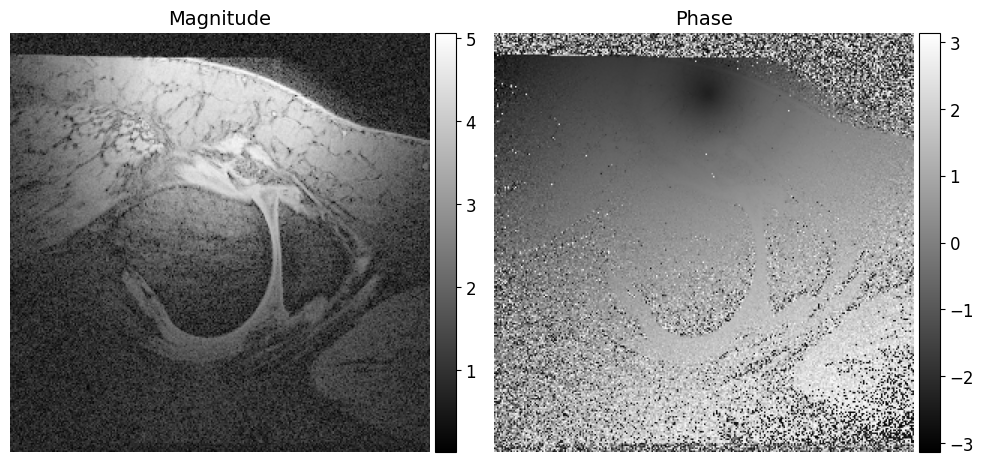

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def butterworth_lowpass_filter(shape, D0=30, n=2):
    """
    Butterworth low-pass filter:
    Produces a blobb reducing the amplitude with the distance from centre==highest frequency domain
    Effectively removes the noise but at the same time grainy signal is  gone too.
    Conserves edge sharpness. 
    shape: (height, width) of image
    D0: cutoff frequency
    n: filter order (higher = sharper transition)
    """
    P, Q = shape
    u = np.arange(P) - P // 2
    v = np.arange(Q) - Q // 2
    U, V = np.meshgrid(u, v, indexing="ij")
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / D0)**(2 * n))
    return H

# Apply filter
shape = kspace[0].shape
bfilter = butterworth_lowpass_filter(shape, D0=20, n=2)
bfiltered = kspace[0] * (1.0 - bfilter)
brealspace = np.fft.ifft2(bfiltered)

# Plot magnitude and phase
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
images = [
    (np.log1p(np.abs(brealspace)), "Magnitude"),
    (np.angle(brealspace), "Phase")
]

for ax, (data, title) in zip(axes, images):
    im = ax.imshow(data, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

    # Add matching colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Combine the realspace images from all coils using root-sum-of-squares
combined = np.zeros_like(abs(gaussian_filtered[0, :, :]), dtype=np.float16)

for i in range(6):
    combined += (abs(gaussian_filtered[i, :, :]))**2.

rss_image = np.sqrt(combined)
log_rss_image = np.log1p(rss_image)

# Plot with colorbar
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(log_rss_image, cmap="gray")
ax.set_title("Weighted RSS")
ax.axis("off")

# Add well-matched colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params()

plt.tight_layout()
plt.show()
